In [ ]:
# Imports
import pandas as pd
import yfinance as yf
import requests
from io import StringIO
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import gdown

# Question 1: [IPO] Withdrawn IPOs by Company Type

What is the total withdrawn IPO value (in $ millions) for the company class with the highest total withdrawal value?

In [ ]:
#Fetch IPO data
url = 'http://stockanalysis.com/ipos/withdrawn/'

In [ ]:
headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

In [ ]:
response = requests.get(url, headers=headers)

In [ ]:
# Wrap HTML text in StringIO to avoid deprecation warning
html_io = StringIO(response.text)

In [ ]:
tables = pd.read_html(html_io)

In [ ]:
# Load the IPO withdrawal table into a DataFrame
df = tables[0]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Symbol          100 non-null    object
 1   Company Name    100 non-null    object
 2   Price Range     100 non-null    object
 3   Shares Offered  100 non-null    object
dtypes: object(4)
memory usage: 3.2+ KB


In [ ]:
df.head()

,Symbol,Company Name,Price Range,Shares Offered
0,ODTX,"Odyssey Therapeutics, Inc.",-,-
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000
2,AURN,"Aurion Biotech, Inc.",-,-
3,ROTR,"PHI Group, Inc.",-,-
4,ONE,One Power Company,-,-


In [ ]:
df['Company Name']

0     Odyssey Therapeutics, Inc.
1         Unifoil Holdings, Inc.
2           Aurion Biotech, Inc.
3                PHI Group, Inc.
4              One Power Company
                 ...            
95     Freehold Properties, Inc.
96                  Chobani Inc.
97    iFIT Health & Fitness Inc.
98    Gerson Lehrman Group, Inc.
99                 hear.com N.V.
Name: Company Name, Length: 100, dtype: object

In [ ]:
# Create a new column called Company Class, categorizing company names based on patterns
company_keywords = {
    'Acq.Corp': ['Acquisition Corp', 'Acquisition Corporation'],
    'Inc': ['Inc', 'Incorporated'],
    'Group': ['Group'],
    'Ltd': ['Ltd', 'Limited'],
    'Holdings': ['Holdings']
}

In [ ]:
def extract_company_class(text, company_type_dict):
    for label, terms in company_type_dict.items():
        for term in terms:
            if re.search(rf'\b{re.escape(term)}\b', text, re.IGNORECASE):
                return label
    return 'Other'

In [ ]:
df['Company Class'] = df['Company Name'].apply(lambda x: extract_company_class(str(x), company_keywords))

In [ ]:
df['Company Class'].value_counts()

Inc         51
Acq.Corp    21
Ltd         17
Other        6
Group        4
Holdings     1
Name: Company Class, dtype: int64

In [ ]:
# Find average prices
df['Price Range'].unique()

array(['-', '$3.00 - $4.00', '$4.00 - $6.00', '$4.00', '$8.00 - $10.00',
       '$2.25', '$4.75', '$4.50 - $5.50', '$4.00 - $5.00',
       '$5.50 - $6.50', '$6.00 - $7.00', '$5.00 - $6.00',
       '$10.00 - $12.00', '$18.00 - $21.00', '$10.00', '$5.00', '$4.25',
       '$4.00 - $4.50', '$5.00 - $7.00', '$16.00 - $19.00', '$4.15',
       '$15.00 - $18.00', '$4.50', '$6.00', '$4.15 - $6.15',
       '$7.50 - $8.00', '$4.25 - $6.25', '$13.00 - $15.00',
       '$9.00 - $11.00', '$17.00 - $20.00'], dtype=object)

In [ ]:
# Define function to calculate average price
def parse_price(price_str):
    if price_str.strip() == '-' or not price_str.strip():
        return None
    # Find all dollar amounts in the string
    prices = re.findall(r"\$([\d\.]+)", price_str)
    if prices:
        prices = list(map(float, prices))
        return round(sum(prices) / len(prices), 2)
    return None

In [ ]:
# Apply function to new column
df['Avg. price'] = df['Price Range'].apply(parse_price)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Symbol          100 non-null    object 
 1   Company Name    100 non-null    object 
 2   Price Range     100 non-null    object 
 3   Shares Offered  100 non-null    object 
 4   Company Class   100 non-null    object 
 5   Avg. price      73 non-null     float64
dtypes: float64(1), object(5)
memory usage: 4.8+ KB


In [ ]:
# Convert Shares Offered to numeric
df['Shares Offered'] = pd.to_numeric(df['Shares Offered'], errors='coerce')

In [ ]:
# Create a new column
df['Withdrawn Value'] = df['Shares Offered']*df['Avg. price']

In [ ]:
# Amount of non-null values
df['Withdrawn Value'].notnull().sum()

71

In [ ]:
#Group by Company Class and calculate total withdrawn value
df.groupby(['Company Class'])['Withdrawn Value'].sum().sort_values(ascending=False)

Company Class
Acq.Corp    4.021000e+09
Inc         2.257164e+09
Other       7.679200e+08
Ltd         5.497346e+08
Holdings    7.500000e+07
Group       3.378750e+07
Name: Withdrawn Value, dtype: float64

# Question 2. [Macro] Indexes YTD (as of 1 May 2025)

What is the median Sharpe ratio (as of 6 June 2025) for companies that went public in the first 5 months of 2024?

In [ ]:
def get_info(url):
    
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
                )
            }
    try:
        response = requests.get(url, headers=headers)
        print("Text corresponding to the status code: ", response.reason)
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)
        if not tables:
            raise ValueError(f"No tables found for {url}")

        return tables[0]
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")
    
    return pd.DataFrame()

In [ ]:
# Download the IPOs in 2024
ipos_2024 = get_info('https://stockanalysis.com/ipos/2024/')

Text corresponding to the status code:  OK


In [ ]:
ipos_2024.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"Dec 31, 2024",ONEG,OneConstruction Group Limited,$4.00,$3.44,3.75%
1,"Dec 27, 2024",PHH,"Park Ha Biological Technology Co., Ltd.",$4.00,$21.91,447.75%
2,"Dec 23, 2024",HIT,"Health In Tech, Inc.",$4.00,$0.59,-85.31%
3,"Dec 23, 2024",TDAC,Translational Development Acquisition Corp.,$10.00,$10.27,2.70%
4,"Dec 20, 2024",RANG,Range Capital Acquisition Corp.,$10.00,$10.20,2.00%


In [ ]:
ipos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      225 non-null    object
 1   Symbol        225 non-null    object
 2   Company Name  225 non-null    object
 3   IPO Price     225 non-null    object
 4   Current       225 non-null    object
 5   Return        225 non-null    object
dtypes: object(6)
memory usage: 10.7+ KB


In [ ]:
ipos_2024['IPO Date'] = pd.to_datetime(ipos_2024['IPO Date'])

In [ ]:
ipos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   IPO Date      225 non-null    datetime64[ns]
 1   Symbol        225 non-null    object        
 2   Company Name  225 non-null    object        
 3   IPO Price     225 non-null    object        
 4   Current       225 non-null    object        
 5   Return        225 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 10.7+ KB


In [ ]:
ipos_2024.tail()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
220,2024-01-18,CCTG,CCSC Technology International Holdings Limited,$6.00,$1.20,-81.83%
221,2024-01-18,PSBD,Palmer Square Capital BDC Inc.,$16.45,$13.91,-11.85%
222,2024-01-12,SYNX,Silynxcom Ltd.,$4.00,$1.73,-56.75%
223,2024-01-11,SDHC,Smith Douglas Homes Corp.,$21.00,$17.60,-16.19%
224,2024-01-09,ROMA,Roma Green Finance Limited,$4.00,$1.99,-30.13%


In [ ]:
# Filter to keep only those IPOs before 1 June 2024 (first 5 months of 2024)
ipos_2024_filtered = ipos_2024[ipos_2024['IPO Date']<'2024-06-01']

In [ ]:
ipos_2024_filtered = ipos_2024_filtered.loc[ipos_2024_filtered['IPO Price'] != '-']

In [ ]:
ipos_2024_filtered['Symbol'].nunique()

75

In [ ]:
ALL_TICKERS = ipos_2024_filtered['Symbol'].reset_index(drop=True)

In [ ]:
ALL_TICKERS

0      BOW
1      HDL
2     RFAI
3     JDZG
4      RAY
      ... 
70    CCTG
71    PSBD
72    SYNX
73    SDHC
74    ROMA
Name: Symbol, Length: 75, dtype: object

In [ ]:
# Download daily stock data for those tickers (via yfinance)
stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker)

  # Work with stock prices
  ticker_obj = yf.Ticker(ticker)

  # historyPrices = yf.download(tickers = ticker,
  #                    period = "max",
  #                    interval = "1d")
  historyPrices = ticker_obj.history(
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90, 252, 365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
  historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-30) / historyPrices['Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(2)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

0 BOW
1 HDL
2 RFAI
3 JDZG
4 RAY
5 BTOC
6 ZK
7 GPAT
8 PAL
9 SVCO
10 NNE
11 CCIX
12 VIK
13 ZONE
14 LOAR
15 MRX
16 RBRK
17 NCI
18 MFI
19 YYGH
20 TRSG
21 CDTG
22 CTRI
23 IBTA
24 MTEN
25 TWG
26 ULS
27 PACS
28 MNDR
29 CTNM
30 MAMO
31 ZBAO
32 BOLD
33 MMA
34 UBXG
35 IBAC
36 AUNA
37 BKHA
38 LOBO
39 RDDT
40 ALAB
41 INTJ
42 RYDE
43 LGCL
44 SMXT
45 VHAI
46 DYCQ
47 CHRO
48 UMAC
49 HLXB
50 MGX
51 TBBB
52 TELO
53 KYTX
54 PMNT
55 AHR
56 LEGT
57 ANRO
58 GUTS
59 AS
60 FBLG
61 AVBP
62 BTSG
63 HAO
64 CGON
65 YIBO
66 JL
67 SUGP
68 JVSA
69 KSPI
70 CCTG
71 PSBD
72 SYNX
73 SDHC
74 ROMA


In [ ]:
stocks_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_90d,growth_252d,growth_365d,growth_future_30d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,is_positive_growth_30d_future
0,23.000000,24.270000,22.139999,23.799999,3335800,0.0,0.0,BOW,2024,5,...,NaN,NaN,NaN,1.092017,NaN,NaN,0,0.089496,NaN,1
1,24.260000,26.150000,23.980000,25.700001,990500,0.0,0.0,BOW,2024,5,...,NaN,NaN,NaN,0.998054,NaN,NaN,0,0.084436,NaN,0
2,25.850000,26.879999,25.075001,26.480000,555100,0.0,0.0,BOW,2024,5,...,NaN,NaN,NaN,1.001133,NaN,NaN,0,0.068165,NaN,1
3,26.440001,26.490000,25.500999,26.290001,302700,0.0,0.0,BOW,2024,5,...,NaN,NaN,NaN,0.987828,NaN,NaN,0,0.037619,NaN,0
4,27.209999,27.209999,25.500000,26.139999,200900,0.0,0.0,BOW,2024,5,...,NaN,NaN,NaN,1.037490,NaN,NaN,0,0.065417,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23166,2.750000,3.153000,2.750000,3.000000,37400,0.0,0.0,ROMA,2025,6,...,4.115226,6.000000,NaN,NaN,3.2610,2.74955,1,0.134333,11.401742,0
23167,3.021000,3.050000,2.850000,2.880000,36300,0.0,0.0,ROMA,2025,6,...,4.241532,5.938144,NaN,NaN,3.2390,2.78955,1,0.069444,10.886753,0
23168,2.870000,2.890000,2.560000,2.660000,123100,0.0,0.0,ROMA,2025,6,...,3.917526,4.666667,NaN,NaN,3.1970,2.82155,1,0.124060,10.383358,0
23169,2.840000,3.000000,2.640000,2.875000,63100,0.0,0.0,ROMA,2025,6,...,4.342900,5.424529,NaN,NaN,3.1485,2.86180,1,0.125217,9.939668,0


In [ ]:
# Calculate the Sharpe ratio assuming a risk-free rate of 4.5%
stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']

In [ ]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [ ]:
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Open                           23171 non-null  float64       
 1   High                           23171 non-null  float64       
 2   Low                            23171 non-null  float64       
 3   Close                          23171 non-null  float64       
 4   Volume                         23171 non-null  int64         
 5   Dividends                      23171 non-null  float64       
 6   Stock Splits                   23171 non-null  float64       
 7   Ticker                         23171 non-null  object        
 8   Year                           23171 non-null  int64         
 9   Month                          23171 non-null  int64         
 10  Weekday                        23171 non-null  int64         
 11  Date           

In [ ]:
# Filter the DataFrame to keep data only for the trading day
stocks_df_filtered = stocks_df[stocks_df['Date'] == '2025-06-06']

In [ ]:
# Compute descriptive statistic
stocks_df_filtered[['growth_252d', 'Sharpe']].describe(percentiles=[0.50])

,growth_252d,Sharpe
count,71.000000,71.000000
mean,1.152898,0.288285
std,1.406017,0.519028
min,0.024970,-0.079677
50%,0.758065,0.083768
max,8.097413,2.835668


# Question 3: [IPO] ‘Fixed Months Holding Strategy’

What is the optimal number of months (1 to 12) to hold a newly IPO'd stock in order to maximize average growth?

In [ ]:
# Start from the existing DataFrame from Question 2
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Open                           23171 non-null  float64       
 1   High                           23171 non-null  float64       
 2   Low                            23171 non-null  float64       
 3   Close                          23171 non-null  float64       
 4   Volume                         23171 non-null  int64         
 5   Dividends                      23171 non-null  float64       
 6   Stock Splits                   23171 non-null  float64       
 7   Ticker                         23171 non-null  object        
 8   Year                           23171 non-null  int64         
 9   Month                          23171 non-null  int64         
 10  Weekday                        23171 non-null  int64         
 11  Date           

In [ ]:
# Create future growth columns using a loop. Add 12 new columns
for month in range(1, 13):
    shift_days = month * 21  # Approx. 21 trading days in a month
    col_name = f'future_growth_{month}m'
    stocks_df[col_name] = stocks_df['Close'].shift(-shift_days) / stocks_df['Close']

In [ ]:
# Determine the first trading day (min_date) for each ticker
min_date_df = stocks_df.groupby(['Ticker'])['Date'].min().sort_values(ascending=False).reset_index()

In [ ]:
min_date_df

,Ticker,Date
0,VHAI,2024-09-11
1,RFAI,2024-07-05
2,GPAT,2024-07-02
3,CCIX,2024-06-21
4,BOW,2024-05-23
...,...,...
70,CCTG,2024-01-18
71,PSBD,2024-01-18
72,SDHC,2024-01-16
73,SYNX,2024-01-12


In [ ]:
stocks_future_growth_df = stocks_df[['Ticker']+['Date']+[f'future_growth_{m}m' for m in range(1, 13)]]

In [ ]:
stocks_future_growth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Ticker             23171 non-null  object        
 1   Date               23171 non-null  datetime64[ns]
 2   future_growth_1m   23150 non-null  float64       
 3   future_growth_2m   23129 non-null  float64       
 4   future_growth_3m   23108 non-null  float64       
 5   future_growth_4m   23087 non-null  float64       
 6   future_growth_5m   23066 non-null  float64       
 7   future_growth_6m   23045 non-null  float64       
 8   future_growth_7m   23024 non-null  float64       
 9   future_growth_8m   23003 non-null  float64       
 10  future_growth_9m   22982 non-null  float64       
 11  future_growth_10m  22961 non-null  float64       
 12  future_growth_11m  22940 non-null  float64       
 13  future_growth_12m  22919 non-null  float64       
dtypes: dat

In [ ]:
# Merging on multiple columns
stocks_df_1st_trade_day = pd.merge(min_date_df, stocks_future_growth_df, left_on=['Ticker', 'Date'], right_on=['Ticker', 'Date'], how='inner')

In [ ]:
stocks_df_1st_trade_day.head()

,Ticker,Date,future_growth_1m,future_growth_2m,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
0,VHAI,2024-09-11,0.431034,0.495690,0.431034,0.422414,0.310345,0.161207,0.103448,0.043103,0.051724,875.862067,878.448251,876.724156
1,RFAI,2024-07-05,1.002191,1.006972,1.007968,1.014940,1.014940,1.017928,1.022908,1.030877,1.035857,1.040837,1.046813,0.174303
2,GPAT,2024-07-02,1.002503,1.007007,1.009009,1.009009,1.013013,1.015015,1.025025,1.026026,1.031031,1.043043,1.054054,1.499499
3,CCIX,2024-06-21,1.000000,0.999003,0.998903,1.001994,1.003490,1.031904,1.028913,1.052842,1.061815,1.080758,1.116650,2.856431
4,BOW,2024-05-23,1.024790,1.139076,1.301681,1.167647,1.239076,1.461765,1.443698,1.357983,1.389076,1.722689,1.698319,1.533613


In [ ]:
stocks_df_1st_trade_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 74
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Ticker             75 non-null     object        
 1   Date               75 non-null     datetime64[ns]
 2   future_growth_1m   75 non-null     float64       
 3   future_growth_2m   75 non-null     float64       
 4   future_growth_3m   75 non-null     float64       
 5   future_growth_4m   75 non-null     float64       
 6   future_growth_5m   75 non-null     float64       
 7   future_growth_6m   75 non-null     float64       
 8   future_growth_7m   75 non-null     float64       
 9   future_growth_8m   75 non-null     float64       
 10  future_growth_9m   75 non-null     float64       
 11  future_growth_10m  75 non-null     float64       
 12  future_growth_11m  75 non-null     float64       
 13  future_growth_12m  75 non-null     float64       
dtypes: datetime6

In [ ]:
desc_df = stocks_df_1st_trade_day.describe()

In [ ]:
desc_df

,future_growth_1m,future_growth_2m,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,0.927259,0.940749,0.833988,0.825192,0.803849,0.864267,0.847205,0.833048,0.881849,12.583914,12.583928,12.603636
std,0.346261,0.574267,0.409480,0.401772,0.488226,0.653079,0.712880,0.762356,0.936895,101.033894,101.336124,101.132460
min,0.098947,0.073800,0.060947,0.045368,0.054109,0.061432,0.048274,0.043103,0.033144,0.041357,0.023674,0.038947
25%,0.778984,0.685815,0.511212,0.517233,0.448403,0.384560,0.296870,0.208677,0.226740,0.245455,0.266821,0.229211
50%,0.977000,1.000000,0.927500,0.909091,0.821092,0.802239,0.844875,0.812109,0.822715,0.777871,0.719512,0.710647
75%,1.046509,1.154013,1.069085,1.134300,1.016381,1.093948,1.114468,1.082438,1.049719,1.244721,1.221407,1.320212
max,2.646505,4.874759,2.040000,1.605000,3.213873,3.670520,5.122350,5.171484,6.764933,875.862067,878.448251,876.724156


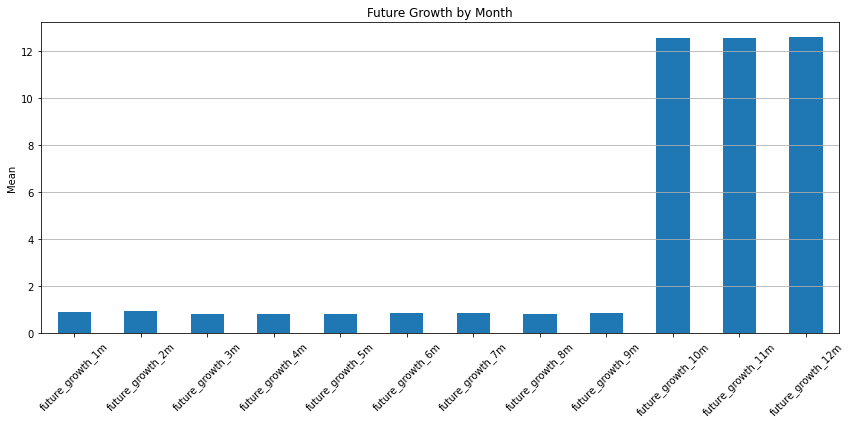

In [ ]:
# Extract only the 'mean' row
means = desc_df.loc['mean']

# Plot
means.plot(kind='bar', figsize=(12, 6), title='Future Growth by Month')

# Add labels
plt.ylabel('Mean')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Question 4: [Strategy] Simple RSI-Based Trading Strategy

What is the total profit (in $thousands) you would have earned by investing $1000 every time a stock was oversold (RSI < 25)?

In [ ]:
# Download precomputed data
file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
df = pd.read_parquet("data.parquet", engine="pyarrow")

Downloading...
From (original): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-
From (redirected): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-&confirm=t&uuid=6d391373-c70c-4b01-b479-5061d66606e8
To: C:\Users\Kirill\Jupyter_notebook\Estate\data.parquet
100%|███████████████████████████████████████████████████████████████████████████████| 130M/130M [00:12<00:00, 10.4MB/s]


In [ ]:
df.head()

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
0,0.054277,0.062259,0.054277,0.059598,1.031789e+09,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.059598,0.062791,0.059598,0.061726,3.081600e+08,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.061726,0.063323,0.061726,0.062791,1.331712e+08,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.062791,0.063323,0.060662,0.061194,6.776640e+07,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.061194,0.061726,0.059598,0.060130,4.789440e+07,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(229932, 203)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229932 entries, 0 to 5690
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 301.7+ MB


In [ ]:
df.rsi.describe()

count    229470.000000
mean         52.972321
std          12.085901
min           0.000000
25%          44.535042
50%          53.066628
75%          61.511647
max         100.000000
Name: rsi, dtype: float64

In [ ]:
# Filter the dataset by RSI and date:
rsi_threshold = 25
selected_df = df[
    (df['rsi'] < rsi_threshold) &
    (df['Date'] >= '2000-01-01') &
    (df['Date'] <= '2025-06-01')
            ]

In [ ]:
selected_df

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
3668,20.056772,20.114241,19.405453,19.673643,99915200.0,0.0,0.0,MSFT,2000,2000-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3669,19.692798,19.807736,19.060636,19.309669,69037800.0,0.0,0.0,MSFT,2000,2000-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3680,18.256067,18.332693,17.317403,17.336559,85374000.0,0.0,0.0,MSFT,2000,2000-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3681,17.279087,17.336557,16.704395,16.991741,136453400.0,0.0,0.0,MSFT,2000,2000-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3682,17.010902,17.547282,16.934277,16.972589,81099400.0,0.0,0.0,MSFT,2000,2000-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,797.393417,806.609179,764.362578,769.289795,7251950.0,0.0,0.0,LT.NS,2020,2020-03-01,...,0.764911,0.515014,0.457056,0.336604,1.181878,1.234663,1.245515,0.610451,0.857647,1.514674
4406,774.673304,800.951963,758.522860,788.998840,6130185.0,0.0,0.0,LT.NS,2020,2020-03-01,...,0.753842,0.491171,0.431611,0.320580,1.001225,1.186226,1.114145,0.643468,0.862000,1.538415
4407,738.175133,739.041975,644.192390,660.662170,7308612.0,0.0,0.0,LT.NS,2020,2020-03-01,...,0.813666,0.496236,0.434706,0.322131,1.100520,1.035093,1.279557,0.663996,0.876243,1.595238
4408,698.550405,699.244329,621.756122,654.971985,7110384.0,10.0,0.0,LT.NS,2020,2020-03-01,...,0.802068,0.509668,0.437480,0.319412,1.049637,1.088881,1.288802,0.678603,0.925726,1.699390


In [ ]:
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1568 entries, 3668 to 4409
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 2.1+ MB


In [ ]:
# Calculate Net Profit Over 25 Years
net_income = 1000*(selected_df['growth_future_30d'] - 1).sum()

In [ ]:
print('$',round(net_income,-3))

$ 24000.0
